In [2]:
import anndata as ad
import pandas as pd
import scanpy as sc
import squidpy as sq
import numpy as np
from scipy import sparse
from anndata import AnnData

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Cluster using Z-normalized CODEX intensities

In [4]:
adata_znorm = ad.read_h5ad('/media/Lynn/data/Integrated_data/adata/adata_filtered_merged_both_slides_codex_znorm_xenium_norm100_log_umap_leiden.h5ad')

In [5]:
adata_znorm

AnnData object with n_obs × n_vars = 902859 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69', 'Podoplanin', 'PNAd', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden', 'annotation', 'DAPI_original', 'FoxP3_original', 'aSMA_original', 'CD4_original', 'CD8_origin

In [12]:
codex_channels = [
    'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 
    'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 
    'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69', 
    'Podoplanin', 'PNAd'
]

In [5]:
# Extract only CODEX intensity data
X_codex_znorm = adata_znorm.obs[codex_channels].values
# Create new AnnData with the same obs
adata_codex_znorm = ad.AnnData(X=X_codex_znorm, obs=adata_znorm.obs.copy(), var=pd.DataFrame(index=codex_channels))

sc.pp.scale(adata_codex_znorm)  
sc.pp.pca(adata_codex_znorm)
sc.pp.neighbors(adata_codex_znorm)
sc.tl.umap(adata_codex_znorm)
sc.tl.leiden(adata_codex_znorm)  

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_89554/3976323207.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_codex_znorm)


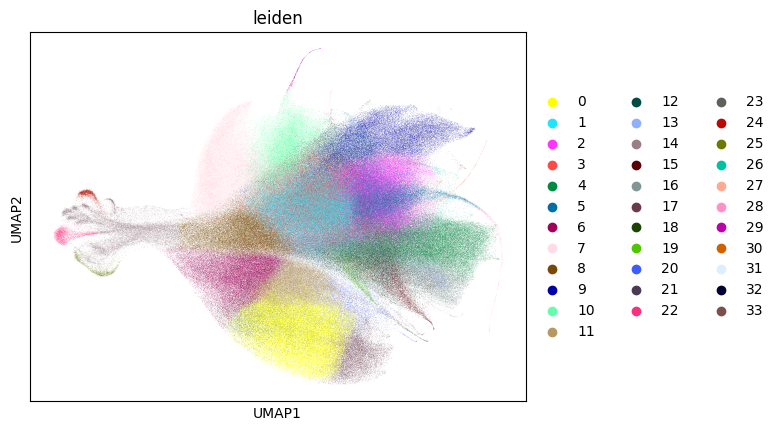

In [6]:
sc.pl.umap(
    adata_codex_znorm,
    color='leiden',
    wspace=0.4,
    save = '_codex_znorm.png'
)

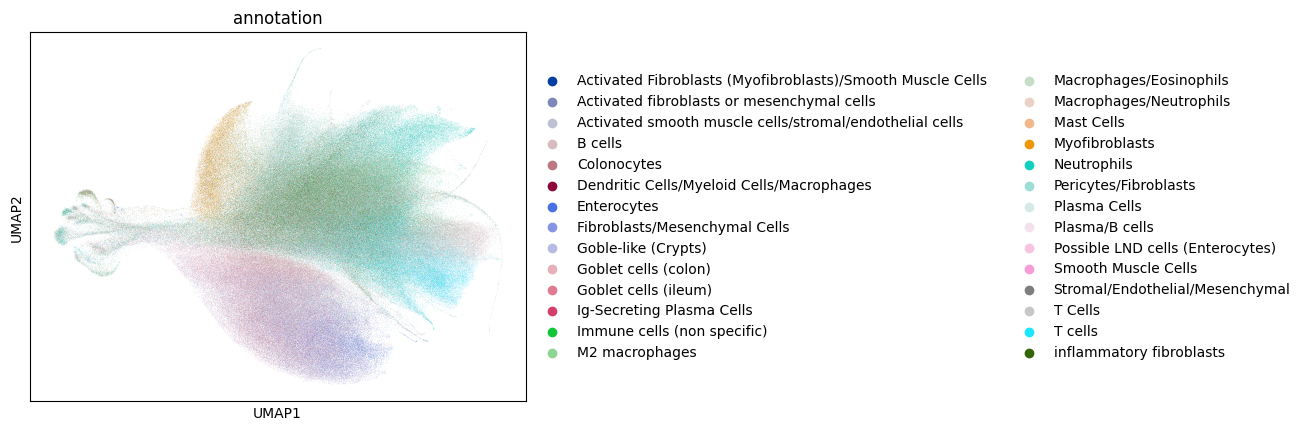

In [7]:
sc.pl.umap(
    adata_codex_znorm,
    color='annotation',
    wspace=0.4,
    save = '_codex_znorm_with_xenium_annotation.png'
)

## Cluster using concatenated Xenium and CODEX measurements

In [45]:
adata_znorm

AnnData object with n_obs × n_vars = 902859 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 'IL10', 'CD45', 'CCR7', 'CD38', 'CD69', 'Podoplanin', 'PNAd', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden', 'annotation', 'DAPI_original', 'FoxP3_original', 'aSMA_original', 'CD4_original', 'CD8_origin

In [46]:
# Step 1: Rename CODEX channel names in obs to have "_CDX" suffix
codex_renamed = [f"{ch}_CDX" for ch in codex_channels]
adata_znorm.obs.rename(columns=dict(zip(codex_channels, codex_renamed)), inplace=True)

# Step 2: Extract normalized gene expression (X) from .X
X_expr = adata_znorm.X.toarray() if sparse.issparse(adata_znorm.X) else adata_znorm.X

# Step 3: Extract renamed CODEX intensity matrix from .obs
X_codex = adata_znorm.obs[codex_renamed].to_numpy()

# Step 4: Concatenate along feature axis (columns)
X_combined = np.concatenate([X_expr, X_codex], axis=1)

# Step 5: Combine var names
combined_var_names = list(adata_znorm.var_names) + codex_renamed

# Step 6: Create new AnnData object
adata_joint = AnnData(X=X_combined, obs=adata_znorm.obs.copy())
adata_joint.var_names = combined_var_names

In [47]:
adata_joint

AnnData object with n_obs × n_vars = 902859 × 446
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI_CDX', 'FoxP3_CDX', 'aSMA_CDX', 'CD4_CDX', 'CD8_CDX', 'CD31_CDX', 'CD11c_CDX', 'IFNG_CDX', 'Pan-Cytokeratin_CDX', 'CD68_CDX', 'CD20_CDX', 'CD66b_CDX', 'TNFa_CDX', 'CD45RO_CDX', 'CD14_CDX', 'CD11b_CDX', 'Vimentin_CDX', 'IL10_CDX', 'CD45_CDX', 'CCR7_CDX', 'CD38_CDX', 'CD69_CDX', 'Podoplanin_CDX', 'PNAd_CDX', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden

In [48]:
adata_joint.obs = adata_joint.obs.rename(columns={
    'leiden': 'leiden_xenium',
    'annotation': 'annotation_xenium'
})

In [54]:
# Exclude DAPI before clustering
features_to_exclude = ['DAPI_CDX']  

# Confirm which are present
features_present = [f for f in features_to_exclude if f in adata_joint.var_names]

# Subset to keep only features that are not DAPI
features_to_keep = [f for f in adata_joint.var_names if f not in features_present]

# Subset the AnnData object to exclude DAPI
adata_joint = adata_joint[:, features_to_keep].copy()

In [55]:
adata_joint

AnnData object with n_obs × n_vars = 902859 × 445
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI_CDX', 'FoxP3_CDX', 'aSMA_CDX', 'CD4_CDX', 'CD8_CDX', 'CD31_CDX', 'CD11c_CDX', 'IFNG_CDX', 'Pan-Cytokeratin_CDX', 'CD68_CDX', 'CD20_CDX', 'CD66b_CDX', 'TNFa_CDX', 'CD45RO_CDX', 'CD14_CDX', 'CD11b_CDX', 'Vimentin_CDX', 'IL10_CDX', 'CD45_CDX', 'CCR7_CDX', 'CD38_CDX', 'CD69_CDX', 'Podoplanin_CDX', 'PNAd_CDX', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden

In [56]:
sc.pp.scale(adata_joint)
sc.pp.pca(adata_joint)
sc.pp.neighbors(adata_joint)
sc.tl.leiden(adata_joint)
sc.tl.umap(adata_joint)

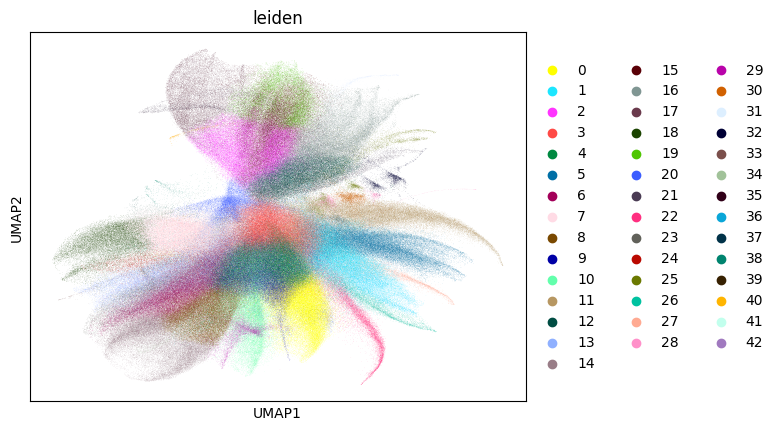

In [57]:
sc.pl.umap(
    adata_joint,
    color='leiden',
    wspace=0.4,
    save = '_joint_xenium_log1p_codex_znorm_all_scaled_DAPI_CDX_excluded.png'
)

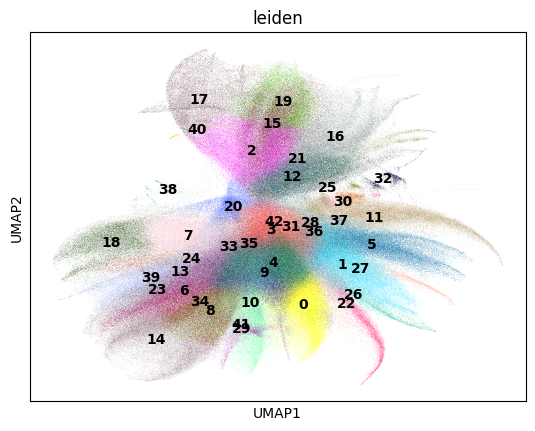

In [67]:
sc.pl.umap(
    adata_joint,
    color='leiden',
    wspace=0.4,
    legend_loc="on data",
    save = '_joint_xenium_log1p_codex_znorm_all_scaled_DAPI_CDX_excluded_with_overlayed_cluster_numbers.png'
)

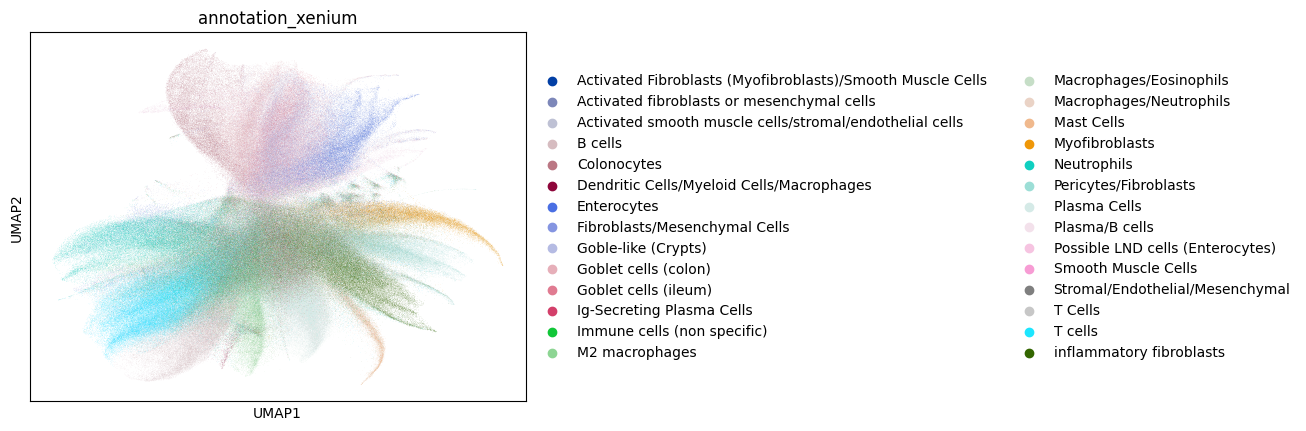

In [68]:
sc.pl.umap(
    adata_joint,
    color='annotation_xenium',
    wspace=0.4,
    save = '_joint_xenium_log1p_codex_znorm_all_scaled_DAPI_CDX_excluded_with_xenium_annotation.png'
)

In [95]:
output_path = "/media/Lynn/data/Integrated_data/adata_concatenated_clustering_codex_znorm_xenium_norm100_log1p_all_scaled_DAPI_CDX_excluded.h5ad"
adata_joint.write(output_path)

In [75]:
adata_with_dapi_cdx = ad.read_h5ad('/media/Lynn/data/Integrated_data/adata_concatenated_clustering_codex_znorm_xenium_norm100_log1p.h5ad')

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [76]:
adata_joint.obs["leiden_wDAPI"] = adata_with_dapi_cdx.obs['leiden']

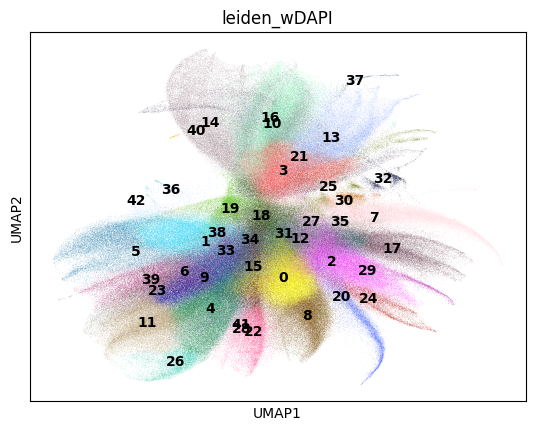

In [77]:
sc.pl.umap(
    adata_joint,
    color='leiden_wDAPI',
    wspace=0.4,
    legend_loc="on data",
    save = '_joint_xenium_log1p_codex_znorm_all_scaled_DAPI_CDX_excluded_with_overlayed_cluster_numbers_with_DAPI.png'
)

## Check marker genes and proteins in each cluster

In [118]:
sc.tl.rank_genes_groups(adata_joint, groupby='leiden_06', method='wilcoxon', key_added='rank_genes_groups_06')

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/scanpy/tools/_rank_genes_grou

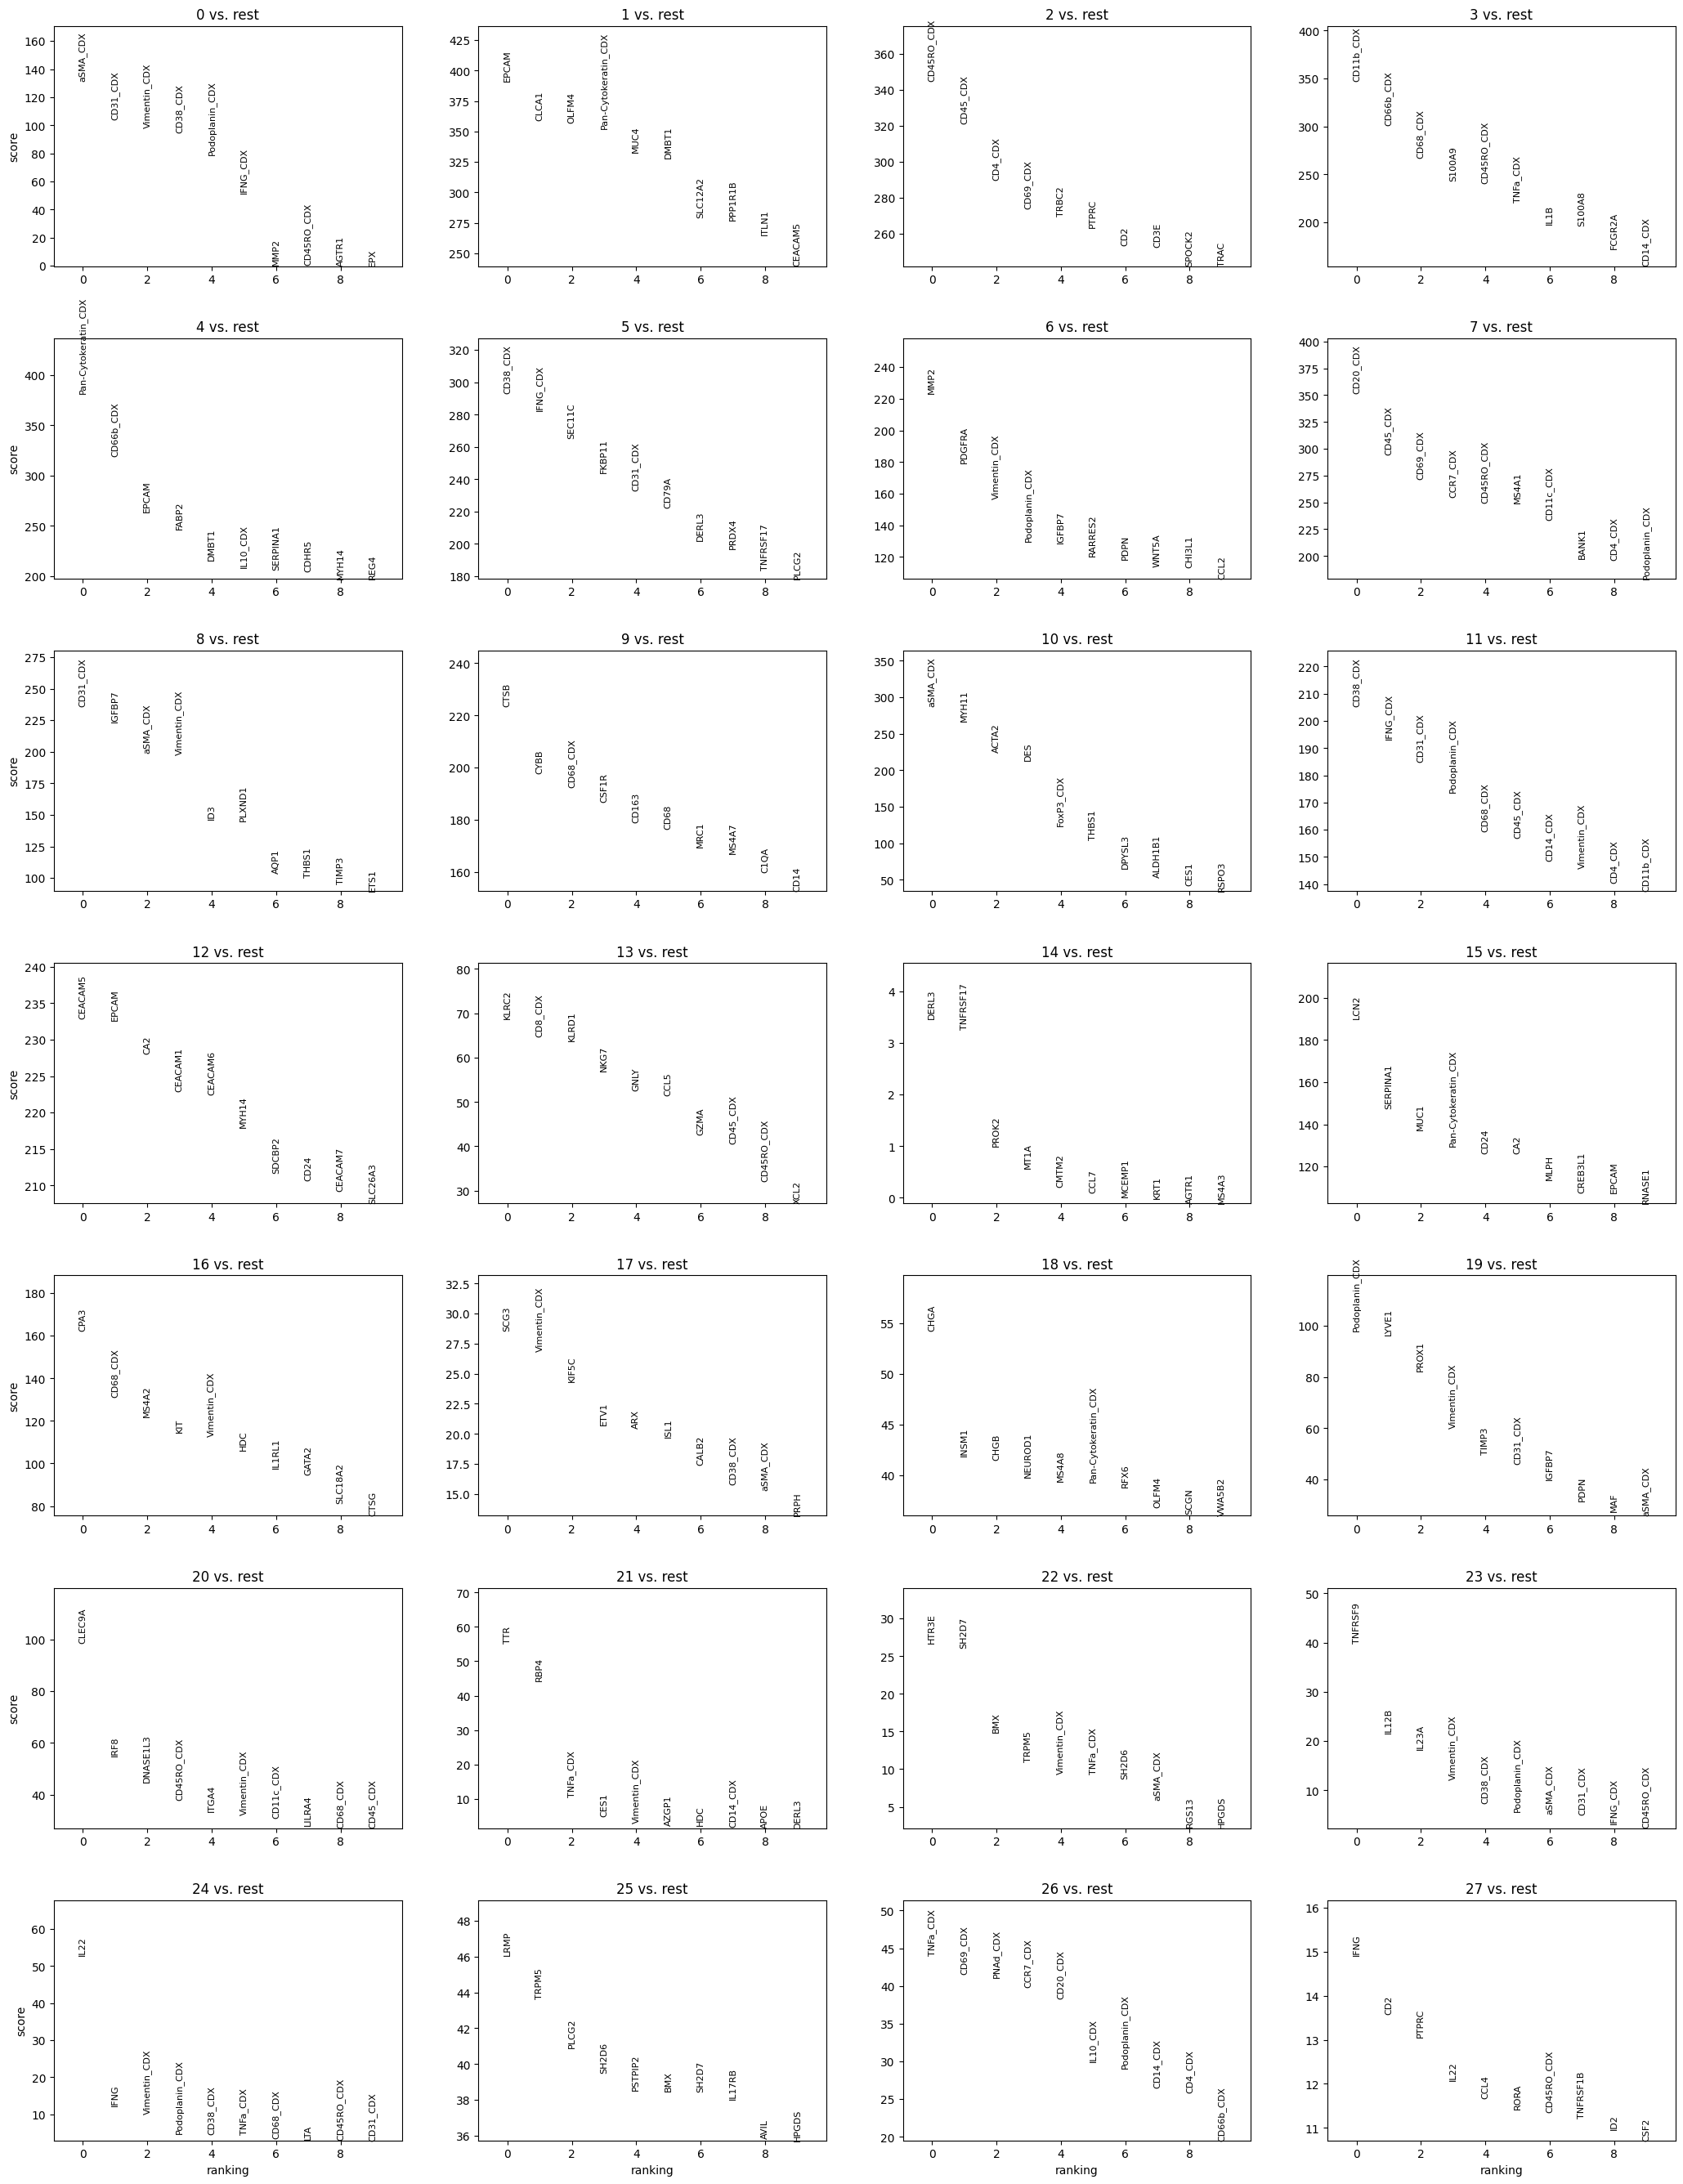

In [119]:
# Plot top genes/proteins across clusters
sc.pl.rank_genes_groups(adata_joint, n_genes=10, key='rank_genes_groups_06', sharey=False, save="_res_06_concatenated_top10_markers_with_cdx_suffix.png")

In [120]:
import scanpy as sc
import matplotlib.pyplot as plt
import math

# Get all cluster names
clusters = adata_joint.obs['leiden_06'].cat.categories.tolist()

# Define number of clusters per figure
batch_size = 8
n_batches = math.ceil(len(clusters) / batch_size)

# Loop over batches and plot
for i in range(n_batches):
    batch_clusters = clusters[i * batch_size:(i + 1) * batch_size]
    
    sc.pl.rank_genes_groups(
        adata_joint,
        groups=batch_clusters,
        n_genes=10,
        key='rank_genes_groups_06',
        sharey=False,
        show=False  # Prevents it from displaying immediately
    )
    
    plt.savefig(f"figures/res_06_ranked_genes_clusters_with_cdx_suffix_{i*batch_size}_{(i+1)*batch_size - 1}.png", dpi=300, bbox_inches='tight')
    plt.close()


In [121]:
from scipy.sparse import issparse

# Convert rank_genes_groups to a DataFrame
def get_rank_genes_df(adata, groupby='leiden', key='rank_genes_groups', n_genes=10):
    result = adata.uns[key]
    groups = result['names'].dtype.names  # e.g. ['0', '1', '2', ...]

    dfs = []
    for group in groups:
        df = pd.DataFrame({
            'gene': result['names'][group][:n_genes],
            'logfoldchange': result['logfoldchanges'][group][:n_genes],
            'pval': result['pvals'][group][:n_genes],
            'pval_adj': result['pvals_adj'][group][:n_genes],
            'score': result['scores'][group][:n_genes],
        })
        df['cluster'] = group
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

# Extract top 10 genes per cluster
markers_df = get_rank_genes_df(adata_joint, groupby='leiden_06', key='rank_genes_groups_06', n_genes=10)

In [122]:
markers_df = markers_df.rename(columns={'gene': 'gene|protein'})
markers_df = markers_df[['cluster', 'gene|protein', 'score', 'pval', 'pval_adj', 'logfoldchange']]

In [123]:
markers_df.to_csv("/media/Lynn/data/Integrated_data/top_markers/res_06_adata_concatenated_codex_znorm_xenium_norm100_log1p_all_scaled_top_markers_per_cluster(DAPI_CDX_excluded).csv", index=False)

## Check CODEX channel intensities distributions and if they are comparable to Xenium measurements

In [92]:
# Identify CODEX and gene feature names
codex_features = [v for v in adata_joint.var_names if v.endswith("_CDX")]
gene_features = [v for v in adata_joint.var_names if not v.endswith("_CDX")]

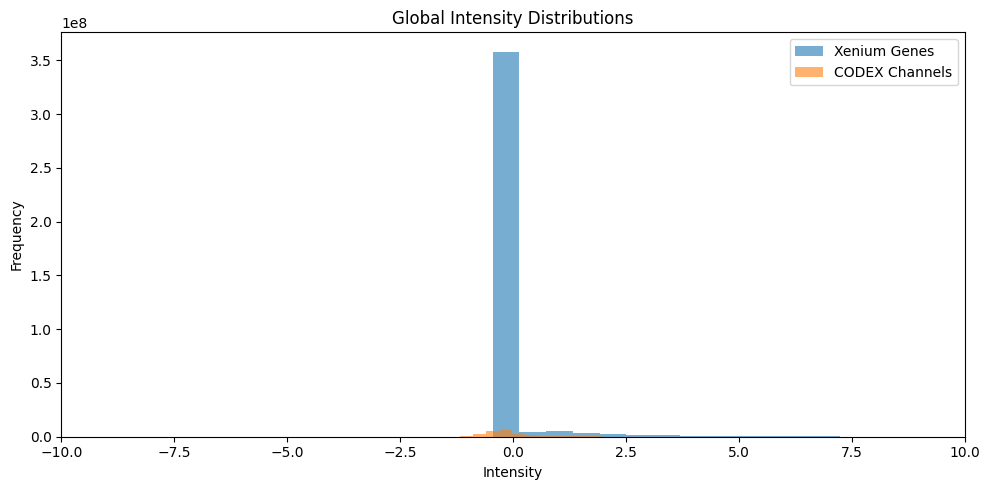

In [93]:
plt.figure(figsize=(10, 5))
plt.hist(adata_joint[:, gene_features].X.flatten(), bins=1000, alpha=0.6, label="Xenium Genes")
plt.hist(adata_joint[:, codex_features].X.flatten(), bins=1000, alpha=0.6, label="CODEX Channels")
plt.legend()
plt.title("Global Intensity Distributions")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.xlim(-10,10)
plt.tight_layout()
plt.savefig("/media/Lynn/pictures/QC/intensity_distributions_xenium_vs_codex.png", dpi=300)
plt.show()

### Check before scaling

In [82]:
adata_znorm= ad.read_h5ad('/media/Lynn/data/Integrated_data/adata_filtered_merged_both_slides_codex_znorm_xenium_norm100_log_umap_leiden.h5ad')

In [83]:
# Step 1: Rename CODEX channel names in obs to have "_CDX" suffix
codex_renamed = [f"{ch}_CDX" for ch in codex_channels]
adata_znorm.obs.rename(columns=dict(zip(codex_channels, codex_renamed)), inplace=True)

# Step 2: Extract normalized gene expression (X) from .X
X_expr = adata_znorm.X.toarray() if sparse.issparse(adata_znorm.X) else adata_znorm.X

# Step 3: Extract renamed CODEX intensity matrix from .obs
X_codex = adata_znorm.obs[codex_renamed].to_numpy()

# Step 4: Concatenate along feature axis (columns)
X_combined = np.concatenate([X_expr, X_codex], axis=1)

# Step 5: Combine var names
combined_var_names = list(adata_znorm.var_names) + codex_renamed

# Step 6: Create new AnnData object
adata_joint_no_scaling = AnnData(X=X_combined, obs=adata_znorm.obs.copy())
adata_joint_no_scaling.var_names = combined_var_names

In [89]:
# Identify CODEX and gene feature names
codex_features = [v for v in adata_joint_no_scaling.var_names if v.endswith("_CDX")]
gene_features = [v for v in adata_joint_no_scaling.var_names if not v.endswith("_CDX")]

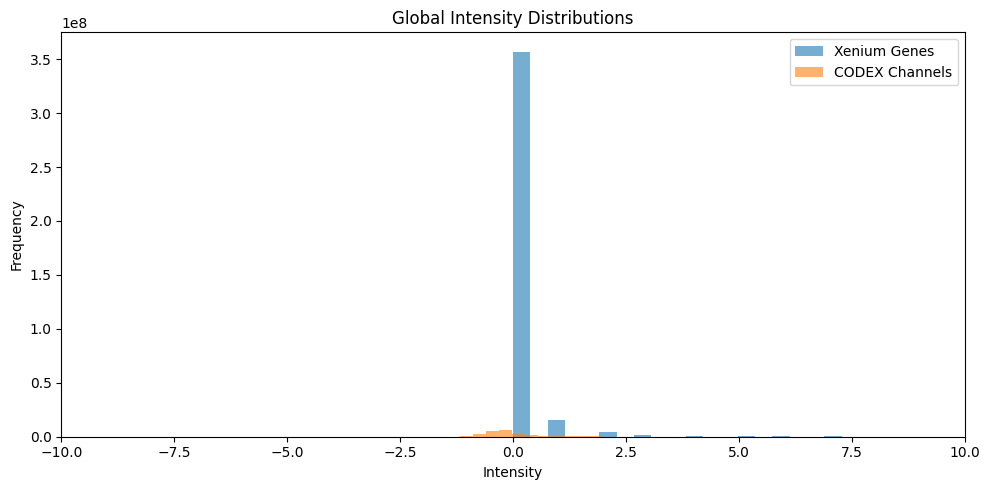

In [91]:
plt.figure(figsize=(10, 5))
plt.hist(adata_joint_no_scaling[:, gene_features].X.flatten(), bins=1000, alpha=0.6, label="Xenium Genes")
plt.hist(adata_joint_no_scaling[:, codex_features].X.flatten(), bins=1000, alpha=0.6, label="CODEX Channels")
plt.legend()
plt.title("Global Intensity Distributions")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.xlim(-10,10)
plt.tight_layout()
plt.savefig("/media/Lynn/pictures/QC/intensity_distributions_xenium_vs_codex_before_scaling.png", dpi=300)
plt.show()

## Try other clustering resolutions

In [104]:
sc.tl.leiden(adata_joint, resolution = 0.6, key_added='leiden_06')
sc.tl.umap(adata_joint, key_added='umap_06')

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [100]:
adata_joint

AnnData object with n_obs × n_vars = 902859 × 445
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'column', 'batch', 'core_ID', 'slide_ID', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'slide_str', 'index', 'DAPI_CDX', 'FoxP3_CDX', 'aSMA_CDX', 'CD4_CDX', 'CD8_CDX', 'CD31_CDX', 'CD11c_CDX', 'IFNG_CDX', 'Pan-Cytokeratin_CDX', 'CD68_CDX', 'CD20_CDX', 'CD66b_CDX', 'TNFa_CDX', 'CD45RO_CDX', 'CD14_CDX', 'CD11b_CDX', 'Vimentin_CDX', 'IL10_CDX', 'CD45_CDX', 'CCR7_CDX', 'CD38_CDX', 'CD69_CDX', 'Podoplanin_CDX', 'PNAd_CDX', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'n_counts', 'leiden

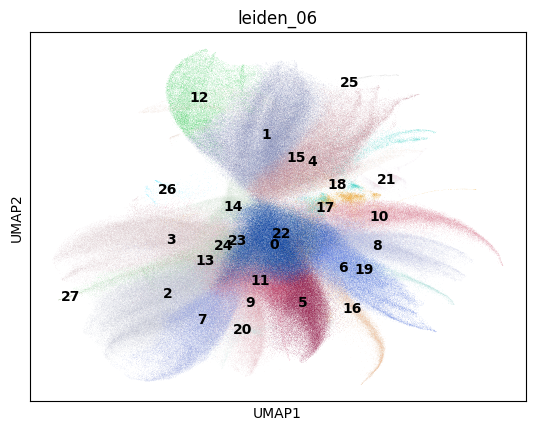

In [105]:
# Backup the original UMAP if needed
adata_joint.obsm['X_umap_original'] = adata_joint.obsm['X_umap']

# Set the new UMAP to be the default for plotting
adata_joint.obsm['X_umap'] = adata_joint.obsm['umap_06']

# Now plot using the new clustering and coordinates
sc.pl.umap(adata_joint, 
    color='leiden_06',
    wspace=0.4,
    legend_loc="on data",
    save = 'res_06_joint_xenium_log1p_codex_znorm_all_scaled_DAPI_CDX_excluded_with_overlayed_cluster_numbers.png'
)

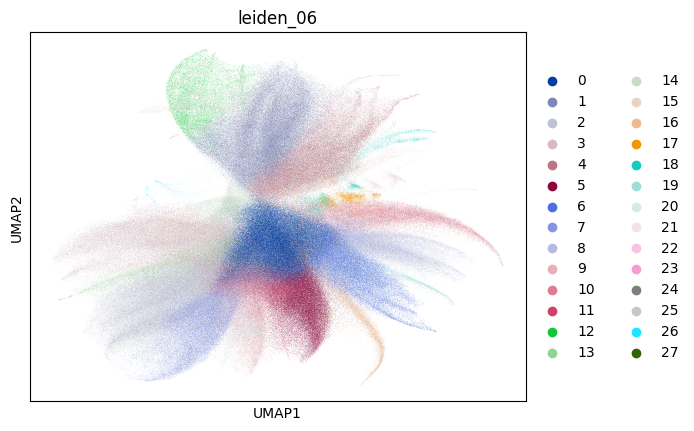

In [106]:
sc.pl.umap(adata_joint, 
    color='leiden_06',
    wspace=0.4,
    save = 'res_06_joint_xenium_log1p_codex_znorm_all_scaled_DAPI_CDX_excluded.png'
)

In [107]:
# Restore the original UMAP afterward
adata_joint.obsm['X_umap'] = adata_joint.obsm['X_umap_original']

# Delete the temporary backup
del adata_joint.obsm['X_umap_original']